# Lab 3 — dimensionality reduction

In [86]:
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pickle

from bokeh.plotting import figure, output_notebook,show, ColumnDataSource
from bokeh.models import HoverTool

from matplotlib.colors import rgb2hex

from operator import itemgetter
from operator import add

%matplotlib inline
plt.style.use("ggplot")
output_notebook()

Loading BokehJS ...

!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

In [2]:
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 2

{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}


In [3]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())
name2tag = {v: k for k, v in tag2name.items()}
# Number of tags
print('There is %d tags'%data.count())

There is 1128 tags


230

In [4]:
data = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
# Number of movies
print('There is %d movies'%data.count())
# Shortest title
print(data.map(lambda movie: (len(movie['title']),movie['title'])).reduce(min))
# Longest title
print(data.map(lambda movie: (len(movie['title']),movie['title'])).reduce(max))

There is 27278 movies
(8, '1 (2013)')
(191, 'Godzilla, Mothra, and King Ghidorah: Giant Monsters All-Out Attack (Gojira, Mosura, Kingu Gidorâ: Daikaijû sôkôgeki) (Godzilla, Mothra and King Ghidorah: Giant Monsters All-Out Attack) (2001)')


In [5]:
data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
distinctMovies = data.map(lambda score: score['movieId']).distinct().count()
print('There is %d movies with tags'%distinctMovies)
distinctTags = data.map(lambda score: score['tagId']).distinct().count()
print('There is %d distinct tags'%distinctTags)

There is 10381 movies with tags
There is 1128 distinct tags


In [6]:
data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
movie2Idx = data.map(lambda score: score['movieId']).distinct().zipWithIndex().collectAsMap()
idx2movie = {v: k for k, v in movie2Idx.items()}

In [7]:
matrix = np.zeros((distinctTags,distinctMovies),dtype=np.float64)
for score in data.map(lambda score: (score['movieId'],score['tagId'],score['relevance'])).collect():
    matrix[score[1]-1,movie2Idx[score[0]]] = score[2]

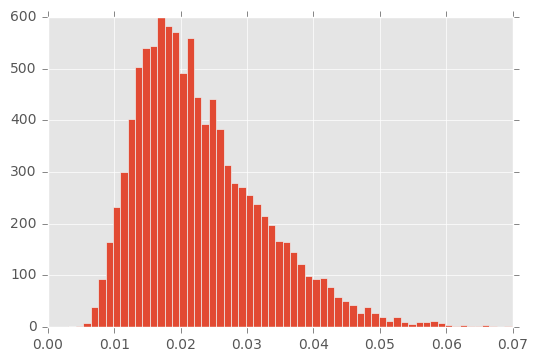

In [8]:
variance = np.var(matrix,0)
plt.hist(variance,'auto');
varianceTot = np.sum(variance)

(1128, 10381)

In [10]:
# Check 
eigenvalues, eigenvectors = la.eigh(np.cov(matrix))
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

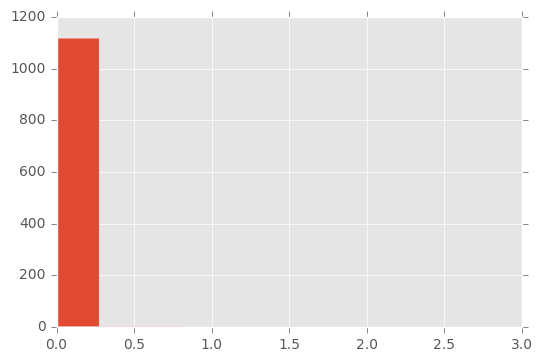

In [20]:
plt.hist(eigenvalues);

In [32]:
eigenvectors[1].shape

(1128,)

In [11]:
targetVar = 2/3.0 * np.sum(eigenvalues)
n = 0
sumVar = 0
for eigenvalue in eigenvalues:
    sumVar += eigenvalue
    n += 1
    if sumVar >= targetVar:
        break
print("We need %d principal direction to capture 2/3 of the variability"%(n))

We need 37 principal direction to capture 2/3 of the variability


In [12]:
V = eigenvectors[:,:5]
smallest = eigenvectors[:,0].argsort()[:10]

(1128, 2)

In [13]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tagName2PCA = {}
for tag in data.map(lambda tag: (tag['tag'],tag['tagId'])).collect():
   tagName2PCA[tag[0]] = V[tag[1]-1]
np.save('tag2pca',tagName2PCA)

In [14]:
numTags=5
goodTags = np.empty((5, numTags),dtype=object)
badTags = np.empty((5, numTags),dtype=object)
for i in range (0,5):
    good = eigenvectors[:,i].argsort()[-numTags:][::-1]
    for idx, val in enumerate(good):
        goodTags[i][idx] = tag2name[val+1]
    bad = eigenvectors[:,i].argsort()[:numTags]
    for idx, val in enumerate(bad):
        badTags[i][idx] = tag2name[val+1]

In [15]:
print(goodTags)
print("Bad:")
print(badTags)

[['talky' 'social commentary' 'criterion' 'imdb top 250' 'great acting']
 ['intimate' 'relationships' 'criterion' 'melancholic' 'loneliness']
 ['feel-good' 'sentimental' 'love story' 'heartwarming' 'touching']
 ['visual' 'visually stunning' 'imagination' 'sci-fi' 'scifi']
 ['thriller' 'conspiracy' 'secrets' 'suspenseful' 'tense']]
Bad:
[['predictable' "so bad it's funny" 'bad plot' 'silly' 'silly fun']
 ['action' 'special effects' 'big budget' 'chase' 'fast paced']
 ['horror' 'weird' 'creepy' 'splatter' 'stylish']
 ['corruption' 'crime' 'murder' 'police investigation' 'thriller']
 ['comedy' 'funny' 'hilarious' 'goofy' 'humorous']]


In [106]:
# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    
data=dict(
            x=[],
            y=[],
            name=[],
            score=[],
            color=[],
        )

for movie in movies:
    coords = matrix.T[movie2Idx[movie[0]]].dot(eigenvectors[:,:2])
    data['x'].append(coords[0])
    data['y'].append(coords[1])
    data['name'].append(movie[1])
    data['score'].append(movie[2])
    data['color'].append(rgb2hex(plt.get_cmap('RdYlGn')(movie[2])[:3]))
source = ColumnDataSource(data)
hover = HoverTool(
        tooltips=[
            ("name", "@name"),
            ("RT score","@score"),
        ]
    )

p = figure(plot_width=600, plot_height=600, tools=[hover],
           title="Movies scores",x_axis_label='bad movies - good movies',y_axis_label='action - sentimental')

p.circle('x', 'y', size=20, source=source, color='color')

show(p)